In [1]:
!pip install -U vllm pynvml matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of model-hosting-container-standards to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.5/466.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 143.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install \
  pandas==2.2.2 \
  fastapi==0.118.0 \
  jedi>=0.16

In [3]:
!pip -q uninstall -y pynvml
!pip -q install -U nvidia-ml-py

In [2]:
from pynvml import nvmlInit, nvmlShutdown
nvmlInit()
nvmlShutdown()
print("NVML ok")

NVML ok


In [3]:
import pandas, fastapi, jedi, torch
from vllm import LLM

print("pandas:", pandas.__version__)
print("fastapi:", fastapi.__version__)
print("jedi:", jedi.__version__)
print("cuda available:", torch.cuda.is_available())

pandas: 2.2.2
fastapi: 0.118.0
jedi: 0.19.2
cuda available: True


In [4]:
import time
import pandas as pd
from vllm import LLM, SamplingParams

MODEL = "Qwen/Qwen2.5-0.5B-Instruct"
llm = LLM(
    model=MODEL,
    gpu_memory_utilization=0.90,
    max_model_len=2048,
)

def make_prompts(workload: str, n: int):
    if workload == "short":
        base = "What is a virtual machine??"
    elif workload == "medium":
        base = "Explain the three parallelisms: data parallelism, pipeline parallelism, and model parallelism, and discuss when to use them."
    elif workload == "long":
        base = ("Write a paper to discuss confidential computing. Make sure to discuss the four security primitives: confidentiality, integrity, attestation, and hardware root of trust, and provide examples to explain each of them. "
                )
    else:
        raise ValueError("workload must be short|medium|long")
    return [base for _ in range(n)]

def count_tokens(outputs):
    total = 0
    for o in outputs:
        out0 = o.outputs[0]
        if hasattr(out0, "token_ids") and out0.token_ids is not None:
            total += len(out0.token_ids)
    return total

def run_once(prompts, max_new_tokens=128, temperature=0.0):
    sp = SamplingParams(temperature=temperature, max_tokens=max_new_tokens)
    t0 = time.perf_counter()
    outs = llm.generate(prompts, sp)
    t1 = time.perf_counter()
    out_tokens = count_tokens(outs)
    return (t1 - t0), out_tokens

INFO 12-16 16:33:10 [utils.py:253] non-default args: {'seed': None, 'max_model_len': 2048, 'disable_log_stats': True, 'model': 'Qwen/Qwen2.5-0.5B-Instruct'}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

WARNING 12-16 16:33:11 [arg_utils.py:1175] `seed=None` is equivalent to `seed=0` in V1 Engine. You will no longer be allowed to pass `None` in v0.13.
INFO 12-16 16:33:31 [model.py:637] Resolved architecture: Qwen2ForCausalLM
INFO 12-16 16:33:31 [model.py:1750] Using max model len 2048
INFO 12-16 16:33:34 [scheduler.py:228] Chunked prefill is enabled with max_num_batched_tokens=8192.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

WARNING 12-16 16:33:37 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 12-16 16:35:05 [llm.py:343] Supported tasks: ['generate']


In [5]:
import threading
import statistics
from pynvml import (
    nvmlInit, nvmlShutdown, nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetUtilizationRates, nvmlDeviceGetMemoryInfo
)

class GpuSampler:
    def __init__(self, device_index=0, interval_s=0.2):
        self.device_index = device_index
        self.interval_s = interval_s
        self._stop = threading.Event()
        self.util = []
        self.mem_mb = []
        self._thr = None

    def start(self):
        nvmlInit()
        h = nvmlDeviceGetHandleByIndex(self.device_index)

        def loop():
            while not self._stop.is_set():
                u = nvmlDeviceGetUtilizationRates(h).gpu
                m = nvmlDeviceGetMemoryInfo(h).used / (1024**2)
                self.util.append(u)
                self.mem_mb.append(m)
                time.sleep(self.interval_s)

        self._thr = threading.Thread(target=loop, daemon=True)
        self._thr.start()

    def stop(self):
        self._stop.set()
        if self._thr:
            self._thr.join(timeout=2.0)
        nvmlShutdown()

    def summary(self):
        def safe_stats(xs):
            if not xs: return (None, None, None)
            return (statistics.mean(xs), max(xs), min(xs))
        util_mean, util_max, util_min = safe_stats(self.util)
        mem_mean, mem_max, mem_min = safe_stats(self.mem_mb)
        return {
            "gpu_util_mean_%": util_mean,
            "gpu_util_max_%": util_max,
            "mem_used_mean_mb": mem_mean,
            "mem_used_max_mb": mem_max,
        }

In [9]:
import math
import pandas as pd

workloads = ["short", "medium", "long"]
batch_sizes = [1, 2, 4, 8, 16]
max_new_tokens_list = [32, 64, 128, 256]

rows = []

# Warmup (keep small so compile/download doesn’t contaminate results)
_ = run_once(make_prompts("short", 2), max_new_tokens=32)

for max_new_tokens in max_new_tokens_list:
    for w in workloads:
        for b in batch_sizes:
            prompts = make_prompts(w, b)

            sampler = GpuSampler(interval_s=0.2)
            sampler.start()

            dt, out_toks = run_once(
                prompts,
                max_new_tokens=max_new_tokens
            )

            sampler.stop()
            g = sampler.summary()

            rows.append({
                "workload": w,
                "batch_size": b,
                "max_new_tokens": max_new_tokens,
                "latency_s_per_batch": dt,
                "latency_s_per_request": dt / b,
                "out_tokens_total": out_toks,
                "tokens_per_s": (out_toks / dt) if dt > 0 else float("nan"),
                **g
            })

df = pd.DataFrame(rows)
df
df.to_csv("vLLM_benchmark_results.csv", index=False)
from google.colab import files
files.download("/content/vLLM_benchmark_results.csv")

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/16 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

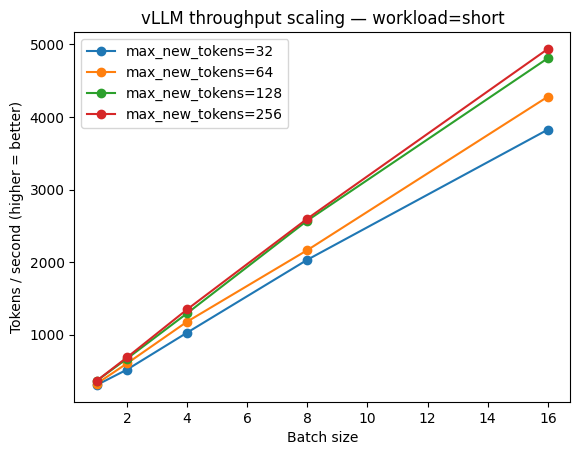

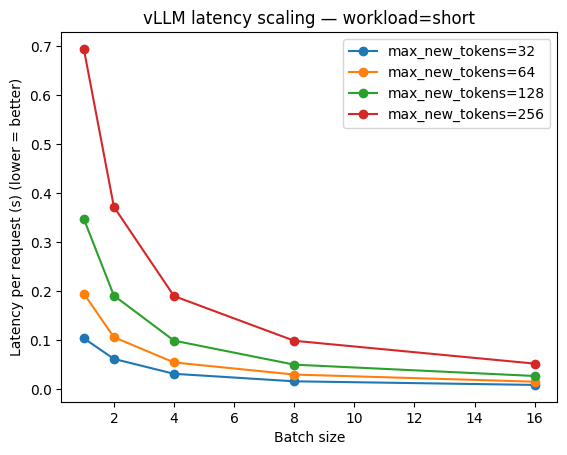

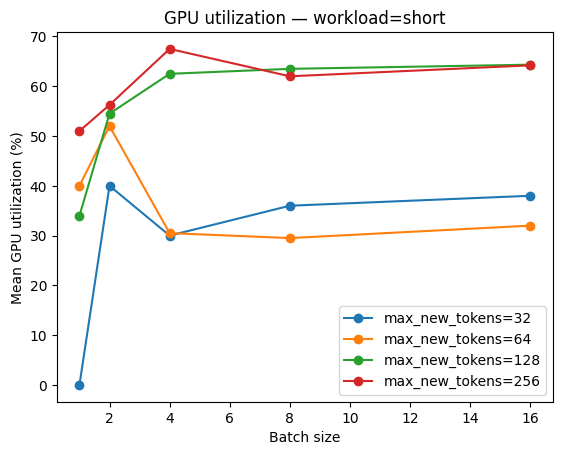

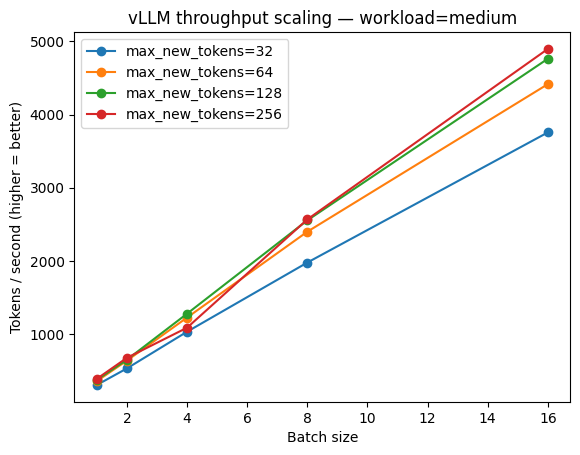

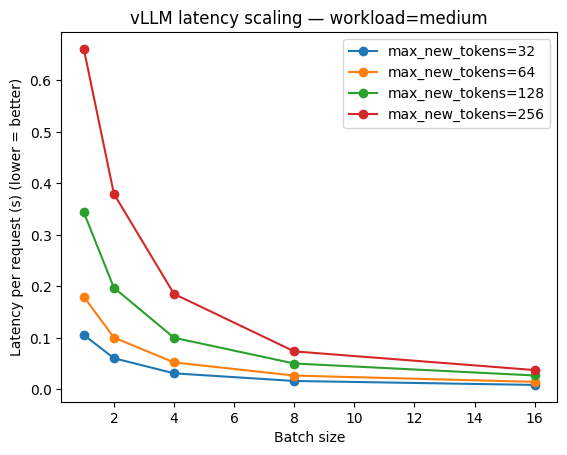

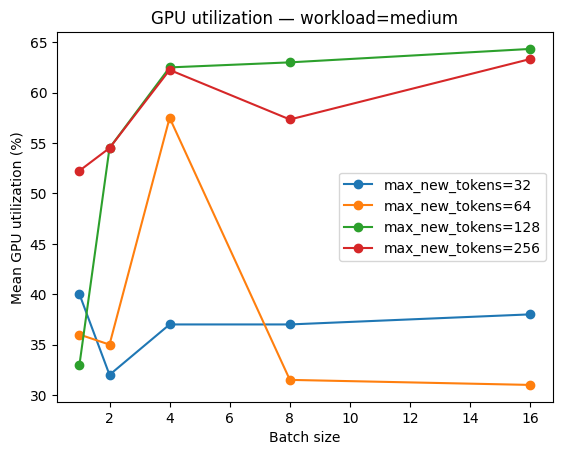

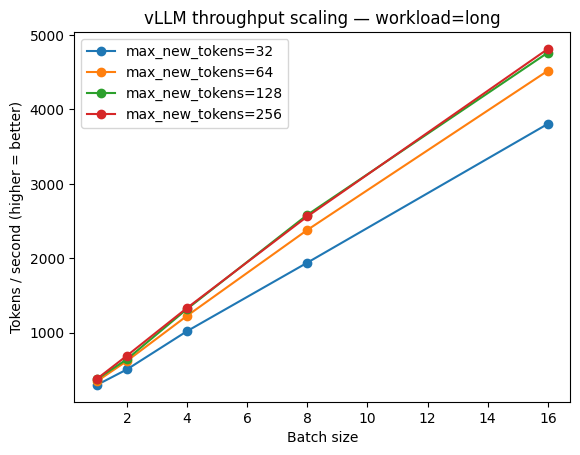

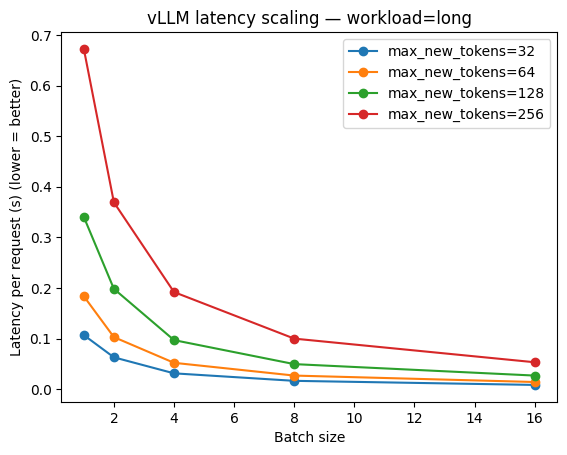

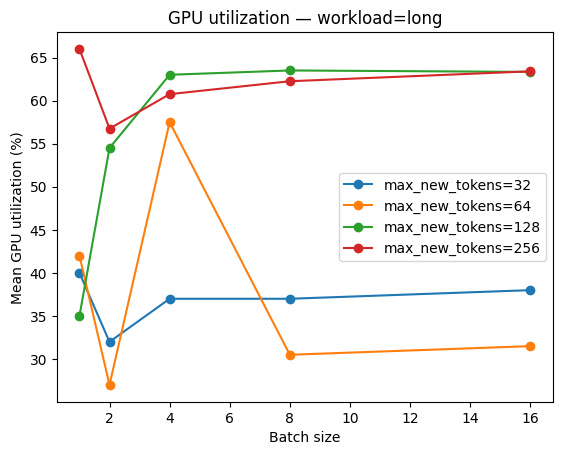

In [10]:
import matplotlib.pyplot as plt

max_new_tokens_list = sorted(df["max_new_tokens"].unique())

for w in workloads:
    # Throughput overlay
    plt.figure()
    for m in max_new_tokens_list:
        sub = df[(df["workload"] == w) & (df["max_new_tokens"] == m)].sort_values("batch_size")
        plt.plot(sub["batch_size"], sub["tokens_per_s"], marker="o", label=f"max_new_tokens={m}")
    plt.xlabel("Batch size")
    plt.ylabel("Tokens / second (higher = better)")
    plt.title(f"vLLM throughput scaling — workload={w}")
    plt.legend()
    plt.show()

    # Latency overlay
    plt.figure()
    for m in max_new_tokens_list:
        sub = df[(df["workload"] == w) & (df["max_new_tokens"] == m)].sort_values("batch_size")
        plt.plot(sub["batch_size"], sub["latency_s_per_request"], marker="o", label=f"max_new_tokens={m}")
    plt.xlabel("Batch size")
    plt.ylabel("Latency per request (s) (lower = better)")
    plt.title(f"vLLM latency scaling — workload={w}")
    plt.legend()
    plt.show()

    # GPU util overlay
    plt.figure()
    for m in max_new_tokens_list:
        sub = df[(df["workload"] == w) & (df["max_new_tokens"] == m)].sort_values("batch_size")
        plt.plot(sub["batch_size"], sub["gpu_util_mean_%"], marker="o", label=f"max_new_tokens={m}")
    plt.xlabel("Batch size")
    plt.ylabel("Mean GPU utilization (%)")
    plt.title(f"GPU utilization — workload={w}")
    plt.legend()
    plt.show()